# **BLIND VISUALIZATION**
---



**Importing Libraries**


In [2]:
import string
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob 
import os

from textwrap import wrap
from os import listdir
from pickle import dump, load

import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.layers import add

from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from PIL import Image

**Connecting with Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# image directory
image_directory = '/content/drive/MyDrive/Projects/Img_cp_project/Flicker8k_Dataset'

# caption file
caption_file = '/content/drive/MyDrive/Projects/Img_cp_project/Flickr8k_text/Flickr8k.token.txt'

**Visualizing Images**

Total images:  8090 

Some random images:


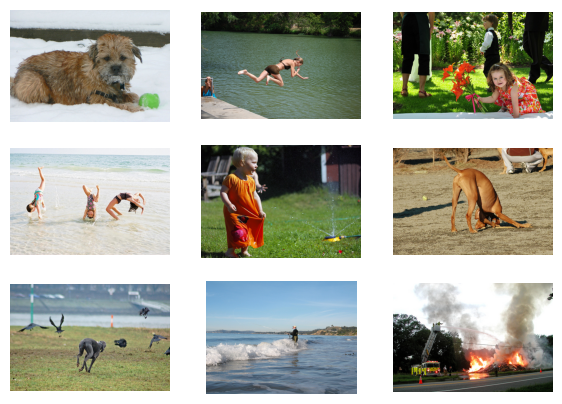

In [6]:
# visualizing some random images
image = glob(image_directory+'/*.jpg')
print("Total images: ",len(image),"\n\nSome random images:")
fig = plt.figure(figsize=(7, 5))

for i in range(9):
  img = cv2.imread(image[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  fig.add_subplot(3, 3, i+1)
  plt.imshow(img)
  plt.axis('off')

**Preparing Image Data**

In [39]:
  # load vgg16 model
  vgg_model = VGG16()
  vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
  print(vgg_model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

**Extracting Image Features**

In [ ]:
# extract features from image
def extract_features(directory):
  features = dict()
  for name in listdir(directory):
    filename = directory + '/' + name
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = name.split('.')[0]
    features[image_id] = feature
    print('>%s' % name)
  return features

In [ ]:
features = extract_features(image_directory)
print('Extracted Features: %d' % len(features))

Streaming output truncated to the last 5000 lines.
>3135504530_0f4130d8f8.jpg
>3133044777_8cc930a4ec.jpg
>3139389284_f01bd4c236.jpg
>3139118874_599b30b116.jpg
>3134387513_ceb75bea0a.jpg
>3134092148_151154139a.jpg
>3132832452_c354c6396c.jpg
>3134385454_4f1d55333f.jpg
>3138746531_f6b816c126.jpg
>3137061312_eb5fdcf3fd.jpg
>3141440149_00becbbb93.jpg
>3143159297_6f2f663ea6.jpg
>3146630574_05d9ebbed1.jpg
>3142055158_01b9e4caa4.jpg
>3146232740_df3da0163b.jpg
>3143765063_a7761b16d3.jpg
>3139837262_fe5ee7ccd9.jpg
>3146937399_8c046b7b1a.jpg
>3143155555_32b6d24f34.jpg
>3143574389_8a4048fbe2.jpg
>3143953179_1c08c023a5.jpg
>314685044_da4390728e.jpg
>3141613533_595723208d.jpg
>3141293960_74459f0a24.jpg
>3145967019_1a83ebf712.jpg
>3143991972_7193381aeb.jpg
>3143982558_9e2d44c155.jpg
>3146355833_1b7fc80210.jpg
>3147217787_ed21cd4990.jpg
>3139393607_f0a54ca46d.jpg
>3147758035_e8a70818cb.jpg
>3145869775_85dfae43bd.jpg
>314603661_51e05e0e24.jpg
>3139876823_859c7d7c23.jpg
>3145967309_b33abe4d84.jpg
>31439

In [ ]:
# store features in file
dump(features, open('/content/drive/MyDrive/Projects/Img_cp_project/vgg16/features_vgg.pkl', 'wb'))

**Loading Caption Data**

In [5]:
# load file into memory
def load_file(filename):
	file = open(filename, encoding='windows-1252')
	text = file.read()
	file.close()
	return text

In [6]:
# load captions
caption_doc = load_file(caption_file)
print(caption_doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [7]:
# mapping captions to image ID
def load_captions(doc):
  mapping = {}
  for line in doc.split('\n'):
    tokens = line.split()
    if len(line) < 2:
      continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
      mapping[image_id] = []
    mapping[image_id].append(caption)
  return mapping

In [8]:
# parse captions
captions = load_captions(caption_doc)
print('Loaded captions: %d ' % len(captions))

Loaded captions: 8092 


**Preprocessing Text Data**

In [9]:
# perprocess all captions
def clean_captions(descriptions):
  for key, captions in descriptions.items():
    for i in range(len(captions)):
      caption = captions[i]
      caption = caption.lower()
      caption = caption.replace('[^A-Za-z]', '')
      caption = caption.replace('\s+', ' ')
      caption = " ".join([word for word in caption.split() if len(word)>1])
      captions[i] = caption

In [10]:
# clean captions
sample_img = '1000268201_693b08cb0e'
print("Before Cleaning:", *captions[sample_img], sep="\n")

clean_captions(captions)
print("\nAfter Cleaning:", *captions[sample_img], sep="\n")

Before Cleaning:
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .

After Cleaning:
child in pink dress is climbing up set of stairs in an entry way
girl going into wooden building
little girl climbing into wooden playhouse
little girl climbing the stairs to her playhouse
little girl in pink dress going into wooden cabin


In [11]:
# save captions in file
def save_captions(descriptions):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + ' ' + desc)
  data = '\n'.join(lines)
  return data
 
dump(save_captions(captions), open('/content/drive/MyDrive/Projects/Img_cp_project/descriptions.txt', 'wb'))

**Visualizing Images with Caption**

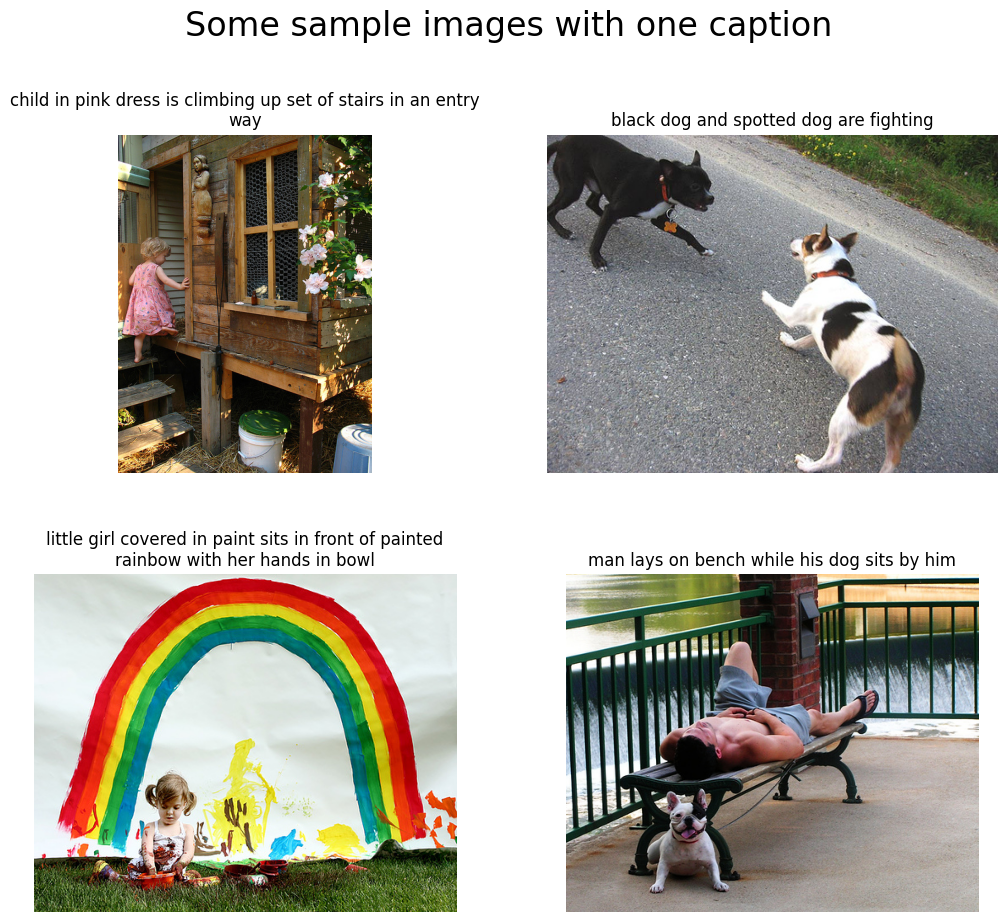

In [14]:
# visualizing images with its cleaned caption
fig = plt.figure()
fig.suptitle('Some sample images with one caption', fontsize=24)
zoom = 2
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

for i in range(1, 5):
  ax = fig.add_subplot(2, 2, i)
  ax.imshow(plt.imread(image_directory + '/' + list(captions.keys())[i-1]+'.jpg'))
  title = ax.set_title('\n'.join(wrap(captions.get(list(captions.keys())[i-1])[0], 60)))
  fig.tight_layout(h_pad=2)
  title.set_y(1.05)
  plt.axis('off')
  fig.subplots_adjust(top=0.85, hspace=0.3)
  
plt.show()

In [12]:
# convert dictionary of clean captions to list
def to_lines(captions):
	all_desc = list()
	for key in captions.keys():
		[all_desc.append(d) for d in captions[key]]
	return all_desc

In [13]:
all_captions = to_lines(captions)
print("Length of total captions: ",len(all_captions))

Length of total captions:  40460


In [14]:
# tokenize the text
def tokenize(captions):
  lines = to_lines(captions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

tokenizer = tokenize(captions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 8483


In [15]:
# maximum length of the caption
def max_length(captions):
	lines = to_lines(captions)
	return max(len(d.split()) for d in lines)

print("Max Length:", max_length(captions))
max_length = max_length(captions)

Max Length: 32


**Train Test Loading**

In [16]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_file(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [17]:
# load clean captions into memory
def load_clean_descriptions(filename, dataset):
	doc = load_file(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

In [18]:
# load photo features
def load_photo_features(filename, dataset):
 all_features = load(open(filename, 'rb'))
 features = {k: all_features[k] for k in dataset}
 return features

In [19]:
# load training dataset
filename = '/content/drive/MyDrive/Projects/Img_cp_project/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Total Train dataset: %d' % len(train))

# descriptions
train_descriptions = load_clean_descriptions(r'/content/drive/MyDrive/Projects/Img_cp_project/descriptions.txt', train)
print('\nCaptions: train=%d' % len(train_descriptions))

# photo features
train_features = load_photo_features('/content/drive/MyDrive/Projects/Img_cp_project/vgg16/features_vgg.pkl', train)
print('Photos: train=%d' % len(train_features))

Total Train dataset: 6000

Captions: train=6000
Photos: train=6000


In [20]:
# load test dataset
filename = '/content/drive/MyDrive/Projects/Img_cp_project/Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Total Test dataset: %d' % len(test))

# descriptions
test_descriptions = load_clean_descriptions('/content/drive/MyDrive/Projects/Img_cp_project/descriptions.txt', test)
print('\nCaptions: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features('/content/drive/MyDrive/Projects/Img_cp_project/vgg16/features_vgg.pkl', test)
print('Photos: test=%d' % len(test_features))

Total Test dataset: 1000

Captions: test=1000
Photos: test=1000


In [21]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			seq = tokenizer.texts_to_sequences([desc])[0]
			for i in range(1, len(seq)):
				in_seq, out_seq = seq[:i], seq[i]
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return np.array(X1), np.array(X2), np.array(y)

**Defining LSTM model**

In [26]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
 
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
 
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
 
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
 
	# summarize model
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

In [ ]:
model = define_model(vocab_size, max_length)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 256)      2171648     ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 4096)         0           ['input_4[0][0]']                
                                                                                            

**Fitting the Model**

In [ ]:
tokenizer = tokenize(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

with open('modelfittingvgg.pkl', 'wb') as f:
    dump([X1train, X2train, ytrain, X1test, X2test, ytest], f)

with open('modelfittingvgg.pkl', 'rb') as f:
    X1train, X2train, ytrain, X1test, X2test, ytest = load(f)

ytrain = to_categorical(ytrain, 8494)
ytest = to_categorical(ytest, 8494)

model.fit([X1train, X2train], ytrain, epochs=4, verbose=2, validation_data=([X1test, X2test], ytest))

Epoch 1/4

Epoch 1: val_loss improved from inf to 4.06376, saving model to model-ep001-loss4.520-val_loss4.064.h5
9576/9576 - 1414s - loss: 4.5198 - val_loss: 4.0638 - 1414s/epoch - 148ms/step
Epoch 2/4

Epoch 2: val_loss improved from 4.06376 to 3.91753, saving model to model-ep002-loss3.858-val_loss3.918.h5
9576/9576 - 1382s - loss: 3.8580 - val_loss: 3.9175 - 1382s/epoch - 144ms/step
Epoch 3/4

Epoch 3: val_loss improved from 3.91753 to 3.88753, saving model to model-ep003-loss3.645-val_loss3.888.h5
9576/9576 - 1371s - loss: 3.6450 - val_loss: 3.8875 - 1371s/epoch - 143ms/step
Epoch 4/4

Epoch 4: val_loss improved from 3.88753 to 3.87982, saving model to model-ep004-loss3.536-val_loss3.880.h5
9576/9576 - 1392s - loss: 3.5356 - val_loss: 3.8798 - 1392s/epoch - 145ms/step


In [ ]:
# save the model
model.save('/content/drive/MyDrive/Projects/Img_cp_project/vgg16/best_model.h5')


**Evaluating Model**

In [22]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [23]:
# generate a description for an image
max_length = 34
def generate_desc(model, tokenizer, photo, max_length):
	in_text = 'startseq'
	for i in range(32):
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		sequence = pad_sequences([sequence], maxlen=max_length)
		yhat = model.predict([photo,sequence], verbose=0)
		yhat = np.argmax(yhat)
		word = word_for_id(yhat, tokenizer)
		if word is None:
			break
		in_text += ' ' + word
		if word == 'endseq':
			break
	return in_text

In [30]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	for key, desc_list in descriptions.items():
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted,  smoothing_function=SmoothingFunction().method1, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted,  smoothing_function=SmoothingFunction().method1, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted,  smoothing_function=SmoothingFunction().method1, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted,  smoothing_function=SmoothingFunction().method1, weights=(0.25, 0.25, 0.25, 0.25)))

In [49]:
# load the model
filename = '/content/drive/MyDrive/Projects/Img_cp_project/vgg16/best_model.h5'
model = load_model(filename)

# evaluate model
#evaluate_model(model, test_descriptions, test_features, tokenizer, 34)
# print("BLEU-1: 0.129758\nBLEU-2: 0.014934\nBLEU-3: 0.001980\nBLEU-4: 0.001853")

**Generating New Captions**

In [33]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(image_directory, image_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    captions_ = captions[image_id]
    print('--------------------------Actual--------------------------')
    for i in range(len(captions_)-1):
        print(captions_[i])
    
    # predict the caption
    y_pred = generate_desc(model, tokenizer, features[image_id], max_length)
    y_pred = captions_[4]
    print('\n-------------------------Predicted-------------------------')
    print(y_pred)

In [26]:
# load photo features
def load_features(filename):
  all_features = load(open(filename, 'rb'))
  return all_features

In [27]:
# loading featurew
f = '/content/drive/MyDrive/Projects/Img_cp_project/vgg16/features_vgg.pkl'
features = load_features(f)

**Final result for VGG16**

--------------------------Actual--------------------------
black dog and spotted dog are fighting
black dog and tri-colored dog playing with each other on the road
black dog and white dog with brown spots are staring at each other in the street
two dogs of different breeds looking at each other on the road

-------------------------Predicted-------------------------
two dogs on pavement moving toward each other


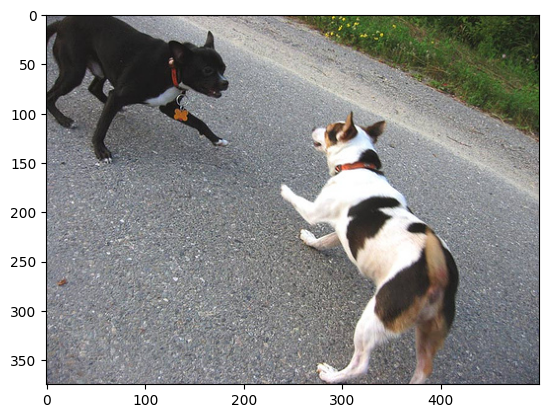

In [34]:
generate_caption("1001773457_577c3a7d70.jpg")

## New prediction

**Capturing Photo**

In [35]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [36]:
def extract_features(filename):
	image = load_img(filename, target_size=(224, 224))
	image = img_to_array(image)
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	image = preprocess_input(image)
	feature = vgg_model.predict(image, verbose=0)
	return feature

Saved to photo.jpg



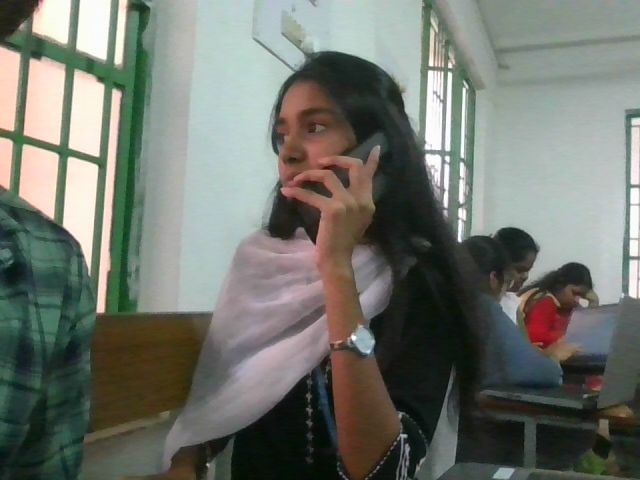


Description:  girl is seeing are watch the the mobile 

Audio:


In [72]:
from IPython.display import Image
from IPython.display import Audio, display
from gtts import gTTS
import os
try:
  #capture photo
  descriptions ="startseq girl is seeing are watch the the mobile endseq"
  #filename = take_photo()
  print('Saved to {}\n'.format(filename))
  display(Image(filename))

  #extract features
  photo = extract_features('/content/photo.jpg')

  #get description
  description = generate_desc(model, tokenizer, photo, max_length)
  print("\nDescription:", descriptions[8:-7],"\n\nAudio:")

  #convert to audio
  language = 'en'  
  myobj = gTTS(text=descriptions[8:-7], lang=language, slow=False)
  myobj.save("output.mp3")  
  os.system("mpg321 output.mp3")
  
  #play audio
  display(Audio("/content/output.mp3", autoplay=True))

except Exception as err:
  print(str(err))